In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, log_loss, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

# Preprocessing

In [2]:
plt.style.use('ggplot')

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv', index_col = 'id')

In [4]:
data = pd.concat([train, test], axis=0)

In [5]:
data.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
id,,,,,,,,,,,,,,,,,
Prague_1_2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1722.0,32575.0
Prague_1_2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1688.0,32507.0
Prague_1_2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1696.0,32552.0
Prague_1_2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.8,0.0,1681.0,32423.0
Prague_1_2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.5,0.0,1704.0,32410.0


In [6]:
data['holiday_name'] = data['holiday_name'].fillna('None')

In [7]:
# Dictionary mapping cities to their countries
city_to_country = {
    'Munich_1': 'Germany',
    'Frankfurt_1': 'Germany',
    'Budapest_1': 'Hungary',
    'Brno_1': 'Czech Republic',
    'Prague_1': 'Czech Republic',
    'Prague_2': 'Czech Republic',
    'Prague_3': 'Czech Republic'
}

data['country'] = data['warehouse'].map(city_to_country)

Credit goes to [Sheikh Muhammad Abdullah](https://www.kaggle.com/abdmental01) in his [notebook](https://www.kaggle.com/code/abdmental01/rohlik-starter-v1) for the following function

In [8]:
def Process_Date(Df):
    Df['date'] = pd.to_datetime(Df['date'])
    Df['year'] = Df['date'].dt.year
    Df['day'] = Df['date'].dt.day
    Df['month'] = Df['date'].dt.month
    Df['quarter'] = Df['date'].dt.quarter
    Df['month_name'] = Df['date'].dt.month_name()
    Df['day_of_week'] = Df['date'].dt.day_name()
    Df['week'] = Df['date'].dt.isocalendar().week
    
    Df['year_sin'] = np.sin(2 * np.pi * Df['year'])
    Df['year_cos'] = np.cos(2 * np.pi * Df['year'])
    Df['month_sin'] = np.sin(2 * np.pi * Df['month'] / 12) 
    Df['month_cos'] = np.cos(2 * np.pi * Df['month'] / 12)
    Df['day_sin'] = np.sin(2 * np.pi * Df['day'] / 31)  
    Df['day_cos'] = np.cos(2 * np.pi * Df['day'] / 31)
    Df['quarter_sin'] = np.sin(2 * np.pi * Df['quarter'] / 4)
    Df['quarter_cos'] = np.cos(2 * np.pi * Df['quarter'] / 4)
    
    Df['group']=(Df['year']-2020)*48+Df['month']*4+Df['day']//7
    Df['total_holidays_month'] = Df.groupby(['year', 'month'])['holiday'].transform('sum')
    Df['total_shops_closed_week'] = Df.groupby(['year', 'week'])['shops_closed'].transform('sum')
    Df['group_sin'] = np.sin(2 * np.pi * Df['group'] / Df['group'].max())
    Df['group_cos'] = np.cos(2 * np.pi * Df['group'] / Df['group'].max())
    return Df

In [9]:
data = Process_Date(data)

In [10]:
# Use only columns we have also in test set
data = data[['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'day', 'month',
       'month_name', 'day_of_week', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'group',
       'total_holidays_month', 'total_shops_closed_week',
       'group_sin', 'group_cos', 'country',
       'orders']]

In [11]:
def apply_tfidf_svd(df, text_column, max_features=1000, n_components=10):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    vectors = vectorizer.fit_transform(df[text_column])
    svd = TruncatedSVD(n_components)
    x_sv = svd.fit_transform(vectors)
    tfidf_df = pd.DataFrame(x_sv)
    cols = [(text_column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis="columns")
    return df

In [12]:
data = apply_tfidf_svd(data,'holiday_name')
data = data.drop(columns=['holiday_name', 'date'])

In [13]:
# Source: https://www.kaggle.com/code/gkanamoto/ensemble-stacking-modified
data['holiday_before'] = data['holiday'].shift(1).fillna(0).astype(int)
data['holiday_after'] = data['holiday'].shift(-1).fillna(0).astype(int)

In [14]:
# Convert some columns to categorical
categorical_columns = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
data[categorical_columns] = data[categorical_columns].astype('category')

In [15]:
# Create dummy features
data = pd.get_dummies(data)

In [16]:
# Rebuild train and test
train = data[~data['orders'].isnull()]
test = data[data['orders'].isnull()]
test = test.drop(columns=['orders'])

In [17]:
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

Train Shape: (7340, 65)
Test Shape: (397, 64)


In [18]:
y = train['orders']
X = train.drop(columns=['orders'])

In [19]:
seed = 1702
np.random.seed(seed)
skf = StratifiedKFold(random_state=seed, shuffle=True)

# Cross Validation

In [20]:
def cross_validation_score(estimator, cv, label=''):
    X = train.copy()
    y = X.pop('orders')
    train_scores, val_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y[train_idx]
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        
        train_score = mean_absolute_percentage_error(y_train, train_preds)
        val_score = mean_absolute_percentage_error(y_val, val_preds)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    return val_scores

In [21]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('rf', RandomForestRegressor(random_state = seed)),
    ('xgb', XGBRegressor(random_state = seed)),
    ('lgb', LGBMRegressor(random_state = seed)),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0)),
    ('ad', AdaBoostRegressor(random_state = seed)),
    ('ex', ExtraTreesRegressor(random_state = seed)),
    ('gb', GradientBoostingRegressor(random_state = seed)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed)),
    ('lir', LinearRegression())
]

In [22]:
for (label, model) in models:
    score_list[label] = cross_validation_score(estimator=model,
                                                                cv=skf,
                                                                label=label)

Val Score: 0.04147 ± 0.00130 | Train Score: 0.01554 ± 0.00019 | rf
Val Score: 0.03486 ± 0.00035 | Train Score: 0.01952 ± 0.00028 | xgb
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 63
[LightGBM] [Info] Start training from score 5537.641860
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 63
[LightGBM] 

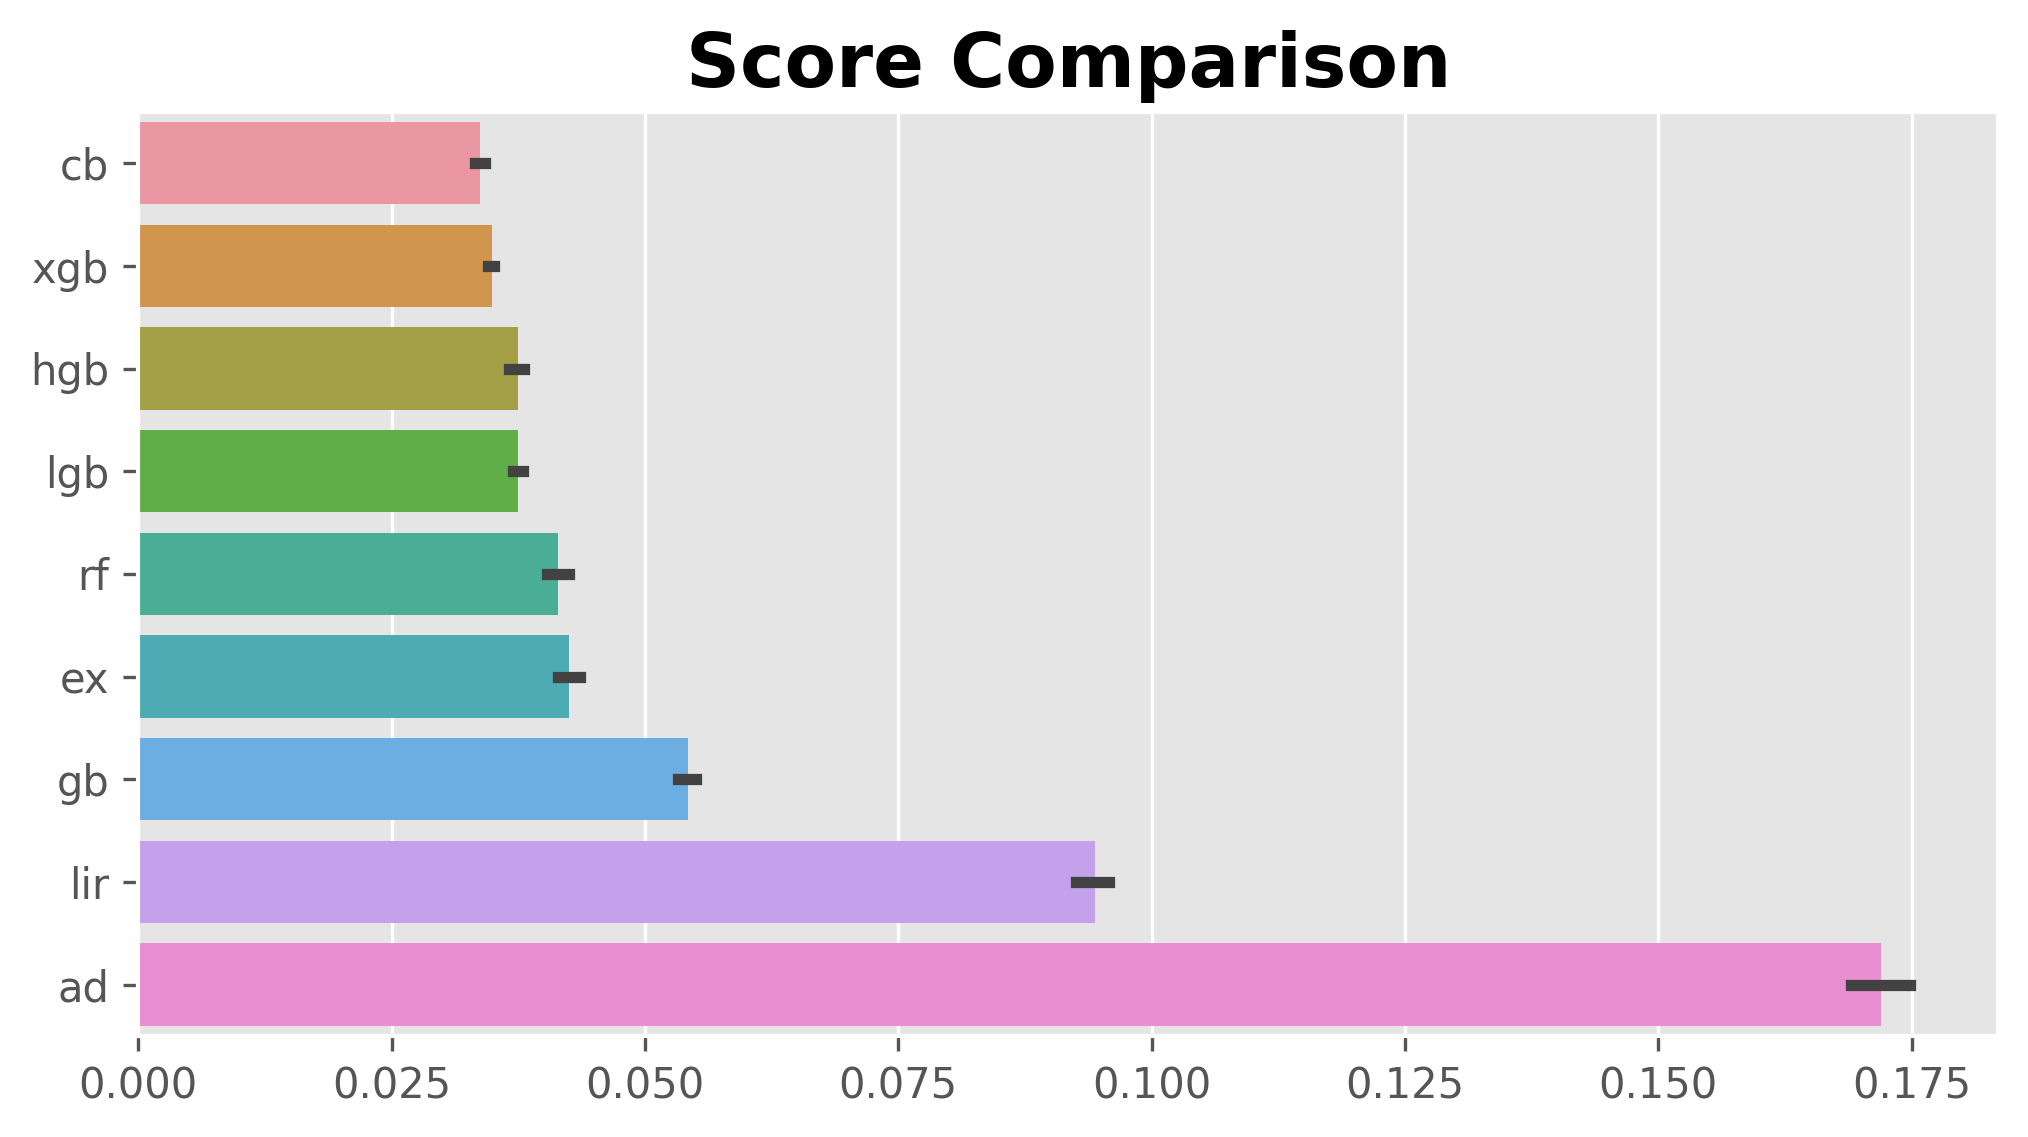

In [23]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values(ascending=False).index, axis = 1), orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 18)
plt.show()

# Voting

In [24]:
# We use the best three models
voting = VotingRegressor(estimators=[
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0)),
    ('xgb', XGBRegressor(random_state = seed)),
    ('hgb', HistGradientBoostingRegressor(random_state = seed))
])

In [25]:
_ = cross_validation_score(estimator=voting, cv=skf, label='voter')

Val Score: 0.03293 ± 0.00054 | Train Score: 0.02394 ± 0.00014 | voter


# Prediction and Submission

In [26]:
voting.fit(X,y)

VotingRegressor(estimators=[('cb',
                             <catboost.core.CatBoostRegressor object at 0x7cfb6688fca0>),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=1702, ...)),
                            ('hgb',
                             HistGradientBoostingRegressor(random_state=1702))])

In [27]:
submission = test.copy()

In [28]:
preds = voting.predict(submission)

In [29]:
submission['orders'] = preds

In [30]:
sub = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv', index_col='id')
sub['orders'] = preds
sub

,orders
id,
Prague_1_2024-03-16,10465.090216
Prague_1_2024-03-17,10156.058332
Prague_1_2024-03-18,9905.335073
Prague_1_2024-03-19,9642.656961
Prague_1_2024-03-20,9664.049660
...,...
Budapest_1_2024-05-11,7371.787144
Budapest_1_2024-05-12,6846.783014
Budapest_1_2024-05-13,7107.026902


In [31]:
sub[['orders']].to_csv('submission.csv')